In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [67]:
import psutil

In [4]:
import gc

In [5]:
import sklearn

In [6]:
import matplotlib.pyplot as plt

In [65]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import Imputer
from sklearn import metrics 
from sklearn.ensemble import VotingClassifier

In [9]:
from sklearn.model_selection import TimeSeriesSplit

In [10]:
sklearn.__version__

'0.18.1'

In [11]:
import pandas as pd
import numpy as np 
import os
import sys
import h5py

In [74]:
cpu_count = int(psutil.cpu_count() / 4 - 2)

In [75]:
cpu_count

20

In [13]:
import serial_preprocess_data as preprocess

In [14]:
data_dir = "../../data/"

In [15]:
hdf_files = sorted([data_dir + file for file in os.listdir(data_dir) 
                    if '.h5' in file])

pick out unique columns from the data. There are not that many relevant features for use. 

In [16]:
columns = ['Year',
        'Cancelled',
        'Distance',
        'Diverted',
        'ArrTime',
        'Dest',
        'FlightNum',
        'DepDelay',
        'ActualElapsedTime',
        'ArrDelay',
        'DayofMonth',
        'UniqueCarrier',
        'Month',
        'DepTime',
        'Origin',
        'DayOfWeek'
        ]

In [17]:
no_of_files = 12

In [18]:
!echo $OMP_NUM_THREADS

22


In [19]:
%time df = preprocess.readFilesToDf("h5", file_list=hdf_files[:no_of_files], cols=columns)

CPU times: user 1min 54s, sys: 10.4 s, total: 2min 4s
Wall time: 1min 8s


In [20]:
preprocess.getFileSizeInGB(hdf_files[:no_of_files])

6.457694441

In [61]:
df.dtypes

ActualElapsedTime    float64
ArrDelay             float64
ArrTime              float64
Cancelled            float64
DayOfWeek            float64
DayofMonth           float64
DepDelay             float64
DepTime              float64
Dest                  object
Distance             float64
Diverted             float64
FlightNum            float64
Month                float64
Origin                object
UniqueCarrier         object
Year                 float64
delayCat             float64
delayBinaryCat          bool
dtype: object

# preprocess data

check the percentage of nans 

In [36]:
def clean_data_minimally(df, verbose=True):
    """remove records with nan values for the target variable (ArrDelay)
    and remove canceled flights from the dataframe
    
    :return: the indices of the valid entries in the dataframe 
    """
    original_df_size = df.shape[0]
    nan_numbers = np.sum(np.isnan(df.ArrDelay)) 
    
    ix = df.ArrDelay.dropna().index
    not_canceled_ix = df.iloc[ix].Cancelled != 1.0
    ix = ix[not_canceled_ix]
    if verbose: 
        print("nan percentage is {0:.2f}".format(
            nan_numbers / df.shape[0] * 100))
        print("removed {} of entries".format(
            original_df_size - df.iloc[ix].shape[0]))
    return ix 

ActualElapsedTime     True
ArrDelay              True
ArrTime               True
Cancelled             True
DayOfWeek             True
DayofMonth            True
DepDelay              True
DepTime               True
Dest                 False
Distance              True
Diverted              True
FlightNum             True
Month                 True
Origin               False
UniqueCarrier        False
Year                  True
delayCat              True
delayBinaryCat       False
dtype: bool

In [113]:
len(df.Dest.unique())

234

In [125]:
find_cardinality_of_categorical_variables(df)

Cardinality of Dest is 234
Cardinality of Origin is 234
Cardinality of UniqueCarrier is 14
Cardinality of delayBinaryCat is 2


In [124]:
def find_cardinality_of_categorical_variables(df):
    cat_variables = np.array(df.columns)[~(df.dtypes == np.float64)]
    for cat in cat_variables:
        print("Cardinality of {0} is {1}".format(
            cat, len(df[cat].unique())))
    return

In [118]:
def encode_label(df, cols):
    
    return 

In [37]:
ix = clean_data_minimally(df)

nan percentage is 1.58
removed 103899 of entries


In [39]:
df.iloc[ix].Cancelled.describe()

count    4666764.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: Cancelled, dtype: float64

In [41]:
df = df.iloc[ix].reindex()

/home/karenyin/miniconda3/py35_envs/idp35_201703/lib/python3.5/site-packages/numpy/lib/function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/home/karenyin/miniconda3/py35_envs/idp35_201703/lib/python3.5/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


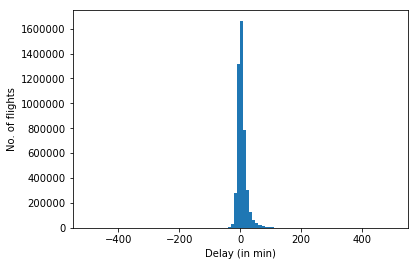

In [42]:
_ = plt.hist(df.ArrDelay, bins=100, range=(-500, 500))
plt.xlabel("Delay (in min)")
plt.ylabel("No. of flights")

In [43]:
df = df.sort_values(by=['DayofMonth', 'Month', 'Year', 'DepTime'])

In [44]:
feature_cols = list(df.columns)
feature_cols.remove('ArrDelay')

In [45]:
def convert_delay_into_multiple_categories(delay):
    if delay >= 30: 
        # very late if delay > 30 mins 
        return 2
    elif delay <= -30: 
        # very early if arrive earlier than 30 min
        return -2 
    elif delay >= -5 and delay <= 5:
         # on time if within 5 minutes of scheduled arrival time 
        return 0
    elif delay >= 5 and delay < 30:
        # late if later than 5 minutes of scheduled arrival time
        # but not later than 30 minutes of scheduled arrival time
        return 1 
    elif delay <= -5 and delay > -30:
        # late if later than 5 minutes of scheduled arrival time
        return -1

In [46]:
def convert_delay_into_two_categories(delay):
    return delay > 5


In [47]:
delays = np.array([-31, -30, -6, -5, 0, 5, 6, 30, 31])

In [49]:
df['delayCat'] = df.ArrDelay.apply(convert_delay_into_multiple_categories)

In [50]:
df['delayBinaryCat'] = df.ArrDelay.apply(convert_delay_into_two_categories)
X = df[feature_cols]
y = df['delayBinaryCat']

In [51]:
df_gpby = df.groupby('delayCat')

In [52]:
delay_percentage_breakdown = df_gpby.ArrDelay.count() / df.shape[0] * 100

In [53]:
delay_percentage_breakdown.index = ['very early', 
                                    'early',
                                    'on time',
                                    'late',
                                    'very late'
                                   ]

In [54]:
delay_percentage_breakdown

very early     0.137654
early         17.046716
on time       41.577590
late          35.068819
very late      6.168986
Name: ArrDelay, dtype: float64

the breakdown is pretty balanced. Although a careful study will also look at the correlation with other features.

In [56]:
tscv = TimeSeriesSplit()

In [58]:
cv_ixes = [(train_ix, test_ix) for train_ix, test_ix in tscv.split(X)]

In [60]:
Imputer

sklearn.preprocessing.imputation.Imputer

In [94]:
rf_pipeline_steps = [
    ("labelEncoder")
    # impute missing feature values with median values 
    ("imputer", Imputer(strategy="median")),  
    ('rf', RandomForestClassifier()),
]

gridsearch_parameters = dict([
    ("rf__n_estimators", [5, 50]),
    ("rf__max_features", [None, 'auto']),  # not many featuers to subset from
])


In [95]:
rf_pipeline = Pipeline(rf_pipeline_steps)

In [96]:
est = GridSearchCV(rf_pipeline,
             param_grid=gridsearch_parameters,
             n_jobs=cpu_count, 
             # use accuracy for scoring for comparing to another benchmark
             scoring=None,  
             cv=tscv.split(X),
            )

In [99]:
clf = RandomForestClassifier(n_estimators=100,)

In [100]:
clf.fit(X.values, y.values)

ValueError: could not convert string to float: 'US'